In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import xgboost as xgb


In [2]:
#load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
# Handle missing values
train_df.fillna('', inplace=True)
test_df.fillna('', inplace=True)

#combine the 2 columns in one
train_texts = train_df['prompt'] + " " + train_df['answer']
test_texts = test_df['prompt'] + " " + test_df['answer']

# Fit the vectorizer on training data
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Labels
y_train = train_df['AI']
mode_label = y_train.mode()[0]
y_train.replace('', mode_label, inplace=True)

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_train = label_encoder.fit_transform(y_train)

# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Implement SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_split, y_train_split)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12944\575772374.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_df.fillna('', inplace=True)


In [4]:
#dataset Statistics
print("Training Data Statistics:")
print(train_df.describe())
print("\nTesting Data Statistics:")
print(test_df.describe())
print("\nTraining Data Info:")
print(train_df.info())
print("\nTesting Data Info:")
print(test_df.info())

Training Data Statistics:
               AI
count  748.000000
mean     0.276738
std      0.447685
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000

Testing Data Statistics:
               ID
count  249.000000
mean   514.658635
std    293.492086
min      0.000000
25%    248.000000
50%    541.000000
75%    770.000000
max    997.000000

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      748 non-null    object 
 1   prompt  748 non-null    object 
 2   answer  748 non-null    object 
 3   AI      748 non-null    float64
dtypes: float64(1), object(3)
memory usage: 23.5+ KB
None

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      249 non-nu

Training data

The mean value of 0.276788 indicates that approximately 27.68% of the texts are AI-generated, while the remaining 72.32% are human-generated.

The quartiles show that a majority of the texts are human-generated, as indicated by the 75th percentile value being 0.

There is a noticeable class imbalance, with fewer AI-generated texts compared to human-generated texts.

Testing data

The ID values are evenly distributed across the range from 0 to 997.
The mean and median values are fairly close, indicating a relatively symmetric distribution of ID values.

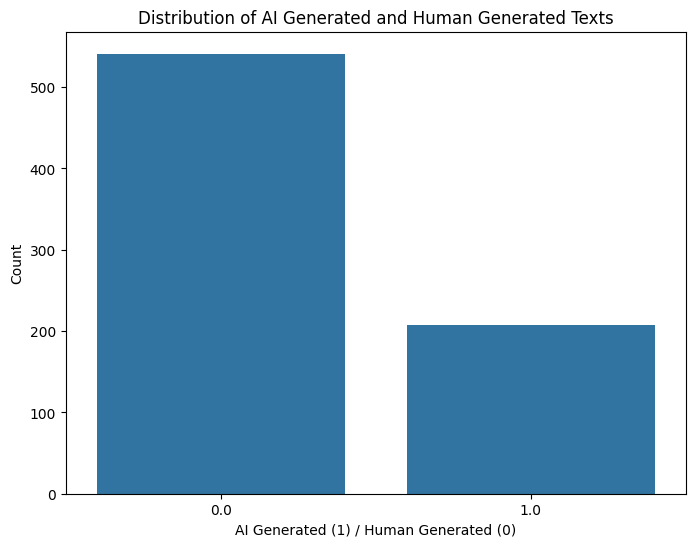

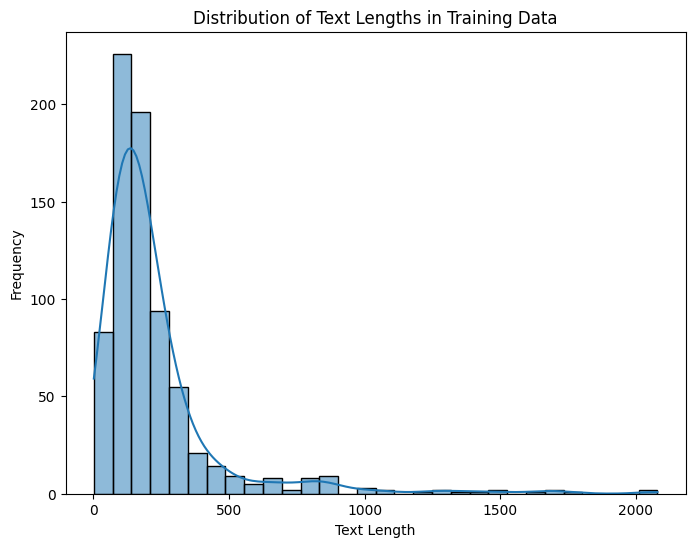

In [5]:
#data Analysis Insights
plt.figure(figsize=(8, 6))
sns.countplot(x='AI', data=train_df)
plt.title('Distribution of AI Generated and Human Generated Texts')
plt.xlabel('AI Generated (1) / Human Generated (0)')
plt.ylabel('Count')
plt.show()

train_df['text_length'] = (train_df['prompt'] + " " + train_df['answer']).apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(train_df['text_length'], kde=True, bins=30)
plt.title('Distribution of Text Lengths in Training Data')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

1. Distribution of AI Generated and Human Generated Texts

Plot Description:

This bar chart shows the count of texts labeled as AI-generated (label 1) and human-generated (label 0).

Observations:

There are significantly more AI-generated texts compared to human-generated texts in the dataset.
The count of AI-generated texts is around 520, while the count of human-generated texts is around 220.

2. Distribution of Text Lengths in Training Data

Plot Description:

This histogram shows the distribution of text lengths in the training data, with a fitted density curve overlayed.

Observations:

Most of the texts are relatively short, with lengths concentrated between 0 and 500 characters.
There are a few texts that are much longer, extending up to 2000 characters, but these are much less frequent.

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.5370 - loss: 1.9244 - val_accuracy: 0.3733 - val_loss: 1.4560
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6754 - loss: 1.3373 - val_accuracy: 0.7133 - val_loss: 1.4140
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8552 - loss: 1.0846 - val_accuracy: 0.7133 - val_loss: 1.3723
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8914 - loss: 1.0233 - val_accuracy: 0.7400 - val_loss: 1.3507
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9253 - loss: 0.9175 - val_accuracy: 0.7267 - val_loss: 1.3090
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9423 - loss: 0.8682 - val_accuracy: 0.7333 - val_loss: 1.2724
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9454 - loss: 0.8376 - val_accuracy: 0.7867 - val_loss: 1.2532
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9610 - loss: 0.7989 - val_accuracy: 0.7533 - v

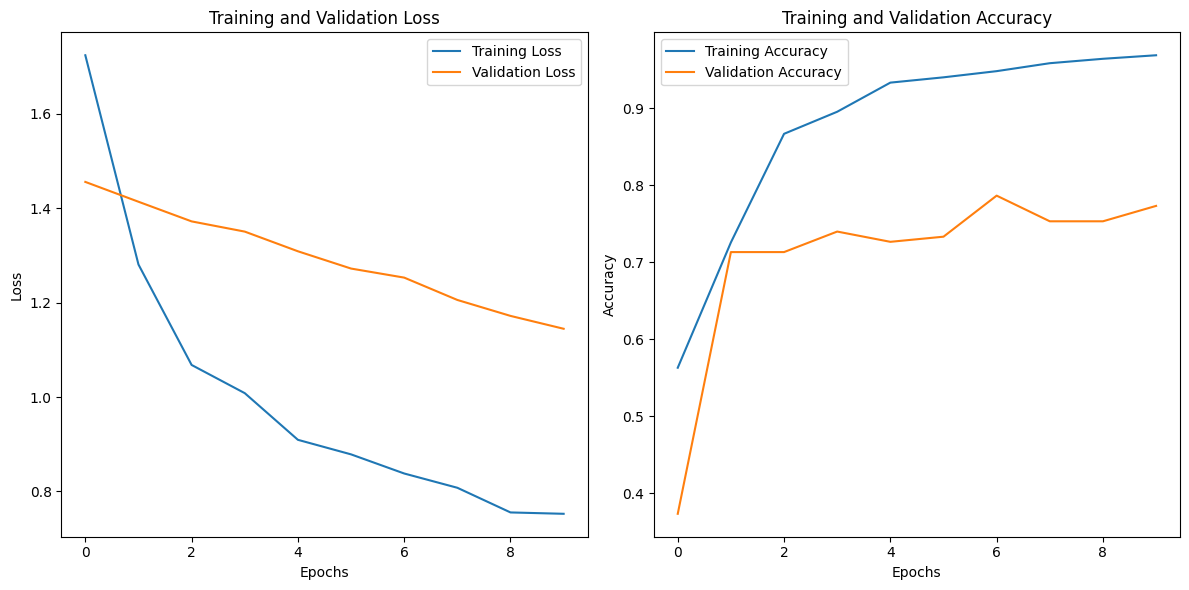

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the neural network model with regularization techniques
def create_nn_model(input_shape, layers=[512, 256, 128], dropout_rate=0.5, learning_rate=0.001, l2_lambda=0.001):
    model = Sequential()
    for layer in layers:
        model.add(Dense(layer, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(l2_lambda)))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model_nn = create_nn_model(input_shape=X_train_split.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model_nn.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_val_split, y_val_split), callbacks=[early_stopping])

# Calculate accuracy for Neural Network
val_loss, val_accuracy = model_nn.evaluate(X_val_split, y_val_split)
print(f"Neural Network Validation Accuracy: {val_accuracy:.4f}")

# Training history plot for Neural Network
history_dict = history.history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



trainning and validation Loss

The training loss decreases steadily over the epochs, indicating that the model is learning and fitting the training data better with each epoch.
By epoch 8, the training loss is very low, suggesting that the model has learned the training data quite well.
The validation loss decreases initially but then starts to plateau after epoch 3.
The plateau in validation loss after epoch 3 indicates that the model may still be overfitting the training data, as it’s not continuing to improve on the validation set.

Training and Validation Accuracy 

The training accuracy increases rapidly and reaches almost 100% by epoch 8.
This high training accuracy suggests that the model is fitting the training data very well, which is consistent with the low training loss observed.
The validation accuracy increases initially but then starts to plateau and slightly fluctuates after epoch 2.
The validation accuracy does not improve significantly after epoch 2, and the slight fluctuations indicate that the model’s performance on the validation set is not improving, which is another sign of overfitting.

Logistic Regression Validation Accuracy: 0.7067


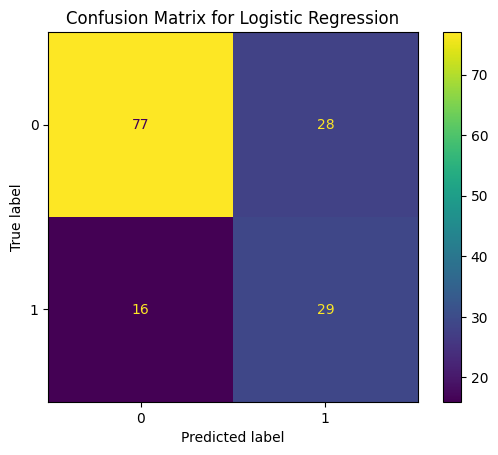

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


#compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights = dict(zip(np.unique(y_train_resampled), class_weights))

#logistic Regression with class weights
model_lr = LogisticRegression(class_weight=class_weights)
model_lr.fit(X_train_resampled, y_train_resampled)

#predict and calculate accuracy
y_val_pred = model_lr.predict(X_val_split)
accuracy_lr = accuracy_score(y_val_split, y_val_pred)
print(f"Logistic Regression Validation Accuracy: {val_accuracy:.4f}")

#plot confusion matrix
cm = confusion_matrix(y_val_split, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for Logistic Regression')
plt.show()



Interpretation

True Negatives (77): These are the instances where the model correctly predicted that the label is 0.

False Positives (28): These are the instances where the model incorrectly predicted the label as 1 when it was actually 0.

False Negatives (16): These are the instances where the model incorrectly predicted the label as 0 when it was actually 1.

True Positives (29): These are the instances where the model correctly predicted that the label is 1.

XGBoost Accuracy: 0.8133


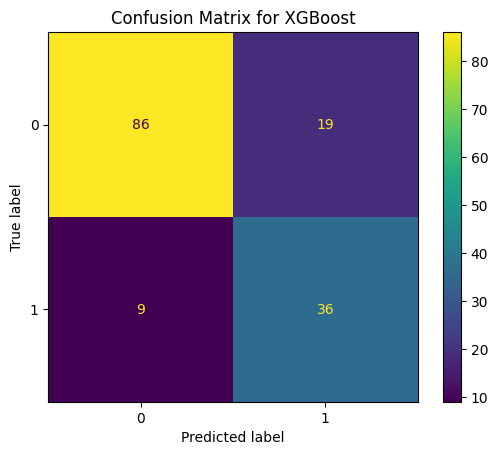

In [13]:
#train XGBoost model
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_resampled, y_train_resampled)

#calculate accuracy for XGBoost
y_val_pred_xgb = model_xgb.predict(X_val_split)
accuracy_xgb = accuracy_score(y_val_split, y_val_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

#plot confusion matrix
cm_xgb = confusion_matrix(y_val_split, y_val_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot()
plt.title('Confusion Matrix for XGBoost')
plt.show()

Interpretation

True Negatives (86): These are the instances where the model correctly predicted that the label is 0.

False Positives (19): These are the instances where the model incorrectly predicted the label as 1 when it was actually 0.

False Negatives (9): These are the instances where the model incorrectly predicted the label as 0 when it was actually 1.

True Positives (36): These are the instances where the model correctly predicted that the label is 1.

In [16]:
#identify the best model based on accuracy
best_model = 'Logistic Regression' if accuracy_lr > max(val_accuracy, accuracy_xgb) else ('Neural Network' if val_accuracy > accuracy_xgb else 'XGBoost')
print(f"The best model is: {best_model}")

The best model is: XGBoost


In [18]:
#test data preprocessing
X_test = vectorizer.transform(test_texts).toarray()

#logistic Regression Predictions
y_test_pred_lr = model_lr.predict(X_test)

#neural Network Predictions
y_test_pred_nn = model_nn.predict(X_test)
y_test_pred_nn = (y_test_pred_nn > 0.5).astype(int)

#XGBoost Predictions
y_test_pred_xgb = model_xgb.predict(X_test)

#create a copy of the submission dataframe for each model's predictions
submission_lr = submission_df[['Id', 'Category']].copy()
submission_nn = submission_df[['Id', 'Category']].copy()
submission_xgb = submission_df[['Id', 'Category']].copy()

#add predictions to each copy
submission_lr['Category'] = y_test_pred_lr
submission_nn['Category'] = y_test_pred_nn
submission_xgb['Category'] = y_test_pred_xgb

#save each to a separate CSV file
submission_lr.to_csv('completed_submission_lr.csv', index=False)
submission_nn.to_csv('completed_submission_nn.csv', index=False)
submission_xgb.to_csv('completed_submission_xgb.csv', index=False)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


1. Logistic Regression (LR)
Advantages:
Simplicity and Interpretability: Logistic Regression is a linear model that is simple to implement and interpret. It provides insights into which features are most influential in making predictions.
Baseline Model: It serves as a strong baseline model for binary classification problems, allowing us to compare the performance of more complex models.
Fast Training: Training and inference with Logistic Regression are computationally efficient, making it suitable for large datasets.
Disadvantages:
Linear Boundaries: Logistic Regression can only model linear relationships between features and the target variable. It may not capture complex patterns in the data.


2. Neural Networks
Advantages:
Complex Relationships: Neural Networks can model complex, non-linear relationships in the data, which is beneficial for tasks where patterns are not linearly separable.
Feature Engineering: Neural Networks can automatically learn feature representations, reducing the need for manual feature engineering.
Flexibility: They can be adapted to various types of data and problem domains, from text to images and beyond.
Disadvantages:
Computational Cost: Neural Networks require significant computational resources for training, especially deep networks with many layers.
Overfitting: They are prone to overfitting, especially on small datasets, requiring careful tuning and regularization.


3. XGBoost
Advantages:
Boosting Algorithm: XGBoost is an ensemble learning method that builds multiple decision trees sequentially, where each tree corrects the errors of the previous ones. This often results in high predictive performance.
Handling Missing Data: XGBoost can handle missing data internally, which simplifies the preprocessing step.
Feature Importance: It provides feature importance scores, helping to understand which features contribute most to the predictions.
Regularization: XGBoost includes regularization parameters that help prevent overfitting.
Disadvantages:
Complexity: XGBoost can be more complex to tune due to the large number of hyperparameters.
Computationally Intensive: Although faster than some other ensemble methods, it can still be computationally intensive, especially with large datasets.


Why Use Multiple Models?


Complementary Strengths: Each model has its strengths and weaknesses. By using multiple models, we can leverage their complementary strengths to achieve better overall performance.
Robustness: Different models may perform better on different subsets of the data or capture different aspects of the data's patterns. Combining their predictions (e.g., through ensemble methods) can lead to more robust and reliable predictions.
Comprehensive Analysis: Evaluating multiple models provides a comprehensive understanding of the problem and helps identify which model is most suitable for the specific task.

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5333 - loss: 0.9293 - val_accuracy: 0.6667 - val_loss: 0.6640
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7147 - loss: 0.5918 - val_accuracy: 0.6667 - val_loss: 0.6432
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8064 - loss: 0.4171 - val_accuracy: 0.6667 - val_loss: 0.6313
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8890 - loss: 0.3075 - val_accuracy: 0.6667 - val_loss: 0.6285
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9124 - loss: 0.2481 - val_accuracy: 0.6667 - val_loss: 0.6340
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9102 - loss: 0.2302 - val_accuracy: 0.6667 - val_loss: 0.6452
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9596 - loss: 0.1583 - val_accuracy: 0.6667 - val_loss: 0.6629
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6854 - loss: 0.6154 
Validation Accuracy for fold: 0.6667
Ep

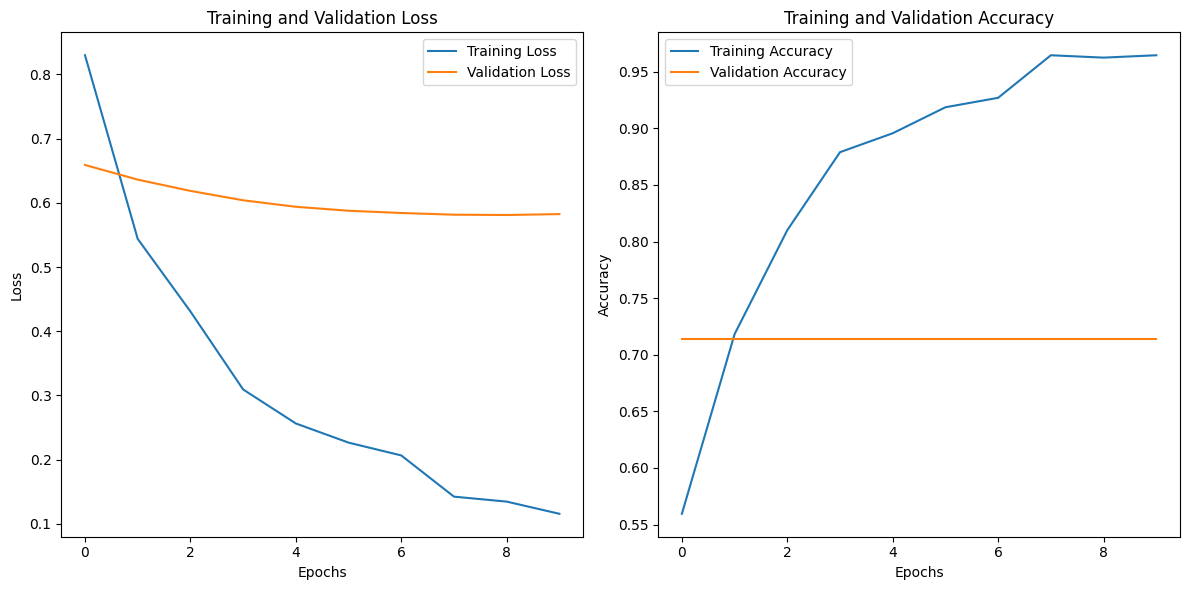

In [29]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Define a simplified neural network model
def create_simplified_nn_model(input_shape, layers=[128, 64], dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    for layer in layers:
        model.add(Dense(layer, activation='relu', input_shape=(input_shape,)))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

X = X_train_split
y = y_train_resampled

# Define KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]
    
    model_nn = create_simplified_nn_model(input_shape=X_train_cv.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model_nn.fit(X_train_cv, y_train_cv, epochs=10, batch_size=32, validation_data=(X_val_cv, y_val_cv), callbacks=[early_stopping])
    
    val_loss, val_accuracy = model_nn.evaluate(X_val_cv, y_val_cv)
    cv_scores.append(val_accuracy)
    print(f"Validation Accuracy for fold: {val_accuracy:.4f}")

# Calculate the mean and standard deviation of the validation accuracy
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
print(f"Mean Validation Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Validation Accuracy: {std_accuracy:.4f}")


# Training history plot for Neural Network
history_dict = history.history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()